## Visualizing 2P Responses to Stimulus

Some of this content is adapted from the [Allen SDK Documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html).

DF/F is one measure of fluorescence. In 2-Photon NWB Files, DF/F is stored in the `Processing` section. The DF/F trace is measured for each region of interest (ROI) in the area being measured. This notebook uses DF/F traces with the stimulus information from the tables in the `Intervals` section of the file to visualize neuron responses to stimulus.

### Environment Setup

In [1]:
import os

import fsspec
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from fsspec.implementations.cached import CachingFileSystem
from pynwb import NWBHDF5IO
from scipy import interpolate

%matplotlib inline

### Downloading 2P File

In [2]:
dandiset_id = "000336"
dandi_filepath = "sub_1170622509/sub_1170622509sess_1194683535/sub_1170622509+sess_1194683535+exp_1194752582_ophys.nwb"
authenticate = True
dandi_api_key = os.environ['DANDI_API_KEY']
download_loc = "."

In [3]:
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"

In [4]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)
print(f"Got dandiset {my_dandiset}")

A newer version (0.48.1) of dandi/dandi-cli is available. You are using 0.46.3


Got dandiset DANDI:000336/draft


In [5]:
file = my_dandiset.get_asset_by_path(dandi_filepath)
# this may take awhile, especially if the file to download is large
file.download(filepath)

print(f"Downloaded file to {filepath}")

Downloaded file to ./sub_1170622509+sess_1194683535+exp_1194752582_ophys.nwb


### Extracting 2P Data and Stimulus Data
Below, the DFF trace and timestamps are read from the file's `Processing` section. Note that the exact format to access the dff trace can vary between newer and older NWB files, so some adjustments may be necessary. Additionally, the stimulus data is also read from the NWB file's `Intervals` section. Stimulus information is stored as a series of tables depending on the type of stimulus shown in the session. One such table is displayed below.

In [6]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read() 

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [7]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(dff_trace.shape)
print(dff_timestamps.shape)

(42337, 103)
(42337,)


In [8]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

['fixed_gabors_presentations', 'gratings_presentations', 'movie_flower_fwd_presentations', 'movie_touch_of_evil_fwd_presentations', 'movie_worms_fwd_presentations', 'rotate_gabors_presentations', 'spontaneous_presentations']


In [9]:
stim_table = nwb.intervals['gratings_presentations']
print(stim_table.colnames)
stim_table[:]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'color', 'contrast', 'mask', 'opacity', 'ori', 'size', 'units', 'stimulus_index', 'spatial_frequency', 'phase', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,color,contrast,mask,opacity,ori,size,units,stimulus_index,spatial_frequency,phase,tags,timeseries
id,,,,,,,,,,,,,,,,
0,3723.084780,3723.385052,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,60.0,"[250.0, 250.0]",deg,7.0,0.08,0.50,[stimulus_time_interval],"[(222259, 18, timestamps pynwb.base.TimeSeries..."
1,3723.385052,3723.685324,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,90.0,"[250.0, 250.0]",deg,7.0,0.08,0.25,[stimulus_time_interval],"[(222277, 18, timestamps pynwb.base.TimeSeries..."
2,3723.685324,3723.985596,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,150.0,"[250.0, 250.0]",deg,7.0,0.08,0.75,[stimulus_time_interval],"[(222295, 18, timestamps pynwb.base.TimeSeries..."
3,3723.985596,3724.285858,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,120.0,"[250.0, 250.0]",deg,7.0,0.08,0.75,[stimulus_time_interval],"[(222313, 18, timestamps pynwb.base.TimeSeries..."
4,3724.285858,3724.586114,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,0.0,"[250.0, 250.0]",deg,7.0,0.08,0.00,[stimulus_time_interval],"[(222331, 18, timestamps pynwb.base.TimeSeries..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,3908.988734,3909.288990,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,120.0,"[250.0, 250.0]",deg,7.0,0.08,0.50,[stimulus_time_interval],"[(233401, 18, timestamps pynwb.base.TimeSeries..."
620,3909.288990,3909.589238,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,150.0,"[250.0, 250.0]",deg,7.0,0.08,0.50,[stimulus_time_interval],"[(233419, 18, timestamps pynwb.base.TimeSeries..."
621,3909.589238,3909.889486,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,90.0,"[250.0, 250.0]",deg,7.0,0.08,0.00,[stimulus_time_interval],"[(233437, 18, timestamps pynwb.base.TimeSeries..."


### Getting Stimulus Epochs
Here, epochs are extracted from the stimulus tables. In this case, an 'epoch' is a continuous period of time during a session where a particular type of stimulus is shown. The output here is a list of epochs, where an epoch is a tuple of four values; the stimulus name, the stimulus block, the starting time and the ending time. Since stimulus information can vary signifcantly between experiments and NWB files, you may need to tailor the code below to extract epochs for the file you're interested in.

In [10]:
# extract epoch times from stim table where stimulus rows have a different 'block' than following row
# returns list of epochs, where an epoch is of the form (stimulus name, stimulus block, start time, stop time)
def extract_epochs(stim_name, stim_table, epochs):
    
    # specify a current_epoch stop and start time
    epoch_start = stim_table.start_time[0]
    epoch_stop = stim_table.stop_time[0]

    # for each row, try to extend current epoch stop_time
    for i in range(len(stim_table)):
        this_block = stim_table.stimulus_block[i]
        # if end of table, end the current epoch
        if i+1 >= len(stim_table):
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            break
            
        next_block = stim_table.stimulus_block[i+1]
        # if next row is the same stim block, push back epoch_stop time
        if next_block == this_block:
            epoch_stop = stim_table.stop_time[i+1]
        # otherwise, end the current epoch, start new epoch
        else:
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            epoch_start = stim_table.start_time[i+1]
            epoch_stop = stim_table.stop_time[i+1]
    
    return epochs

In [11]:
# extract epochs from all valid stimulus tables
epochs = []
for stim_name in stimulus_names:
    stim_table = nwb.intervals[stim_name]
    try:
        epochs = extract_epochs(stim_name, stim_table, epochs)
    except:
        continue

# epochs take the form (stimulus name, stimulus block, start time, stop time)
print(len(epochs))
epochs.sort(key=lambda x: x[2])
for epoch in epochs:
    print(epoch)

185
('movie_touch_of_evil_fwd_presentations', 0.0, 30.02491, 39.03236712068045)
('movie_flower_fwd_presentations', 1.0, 40.03322000000001, 49.04066712068045)
('movie_flower_fwd_presentations', 2.0, 50.041520000000006, 59.04897712068045)
('movie_touch_of_evil_fwd_presentations', 3.0, 60.04983, 69.05729712068045)
('movie_flower_fwd_presentations', 4.0, 70.05813, 79.06559712068045)
('movie_worms_fwd_presentations', 5.0, 80.06644, 89.07389712068046)
('movie_worms_fwd_presentations', 6.0, 90.07477, 99.08223712068045)
('movie_flower_fwd_presentations', 7.0, 100.08306, 109.09053712068044)
('movie_touch_of_evil_fwd_presentations', 8.0, 110.09139, 119.09884712068046)
('movie_worms_fwd_presentations', 9.0, 120.0997, 129.10716712068046)
('movie_touch_of_evil_fwd_presentations', 10.0, 130.10802, 139.11548712068046)
('movie_worms_fwd_presentations', 11.0, 140.11631, 149.12378712068045)
('movie_flower_fwd_presentations', 12.0, 150.12465, 159.13208712068044)
('movie_worms_fwd_presentations', 13.0, 16

### Visualizing DF/F Activity Throughout Epochs
Below is a view of the dff activity of a channel throughout a session, where epochs are shown as colored sections. Set `roi_num` to be the id of the ROI you want to view. Set `time_start` to the starting bound in seconds of the session, you'd like to see, and `time_end` to the ending bound. You may want to use the output above to inform your choice. As mentioned above, if your file's stimulus information differs signifcantly, this code may need to be modified to appropriately display the epochs. You may also change `trace_to_display` to select the average dff trace for all ROIs.

In [12]:
roi_num = 13 # chosen from dff_trace.shape[1]
time_start = 0
time_end = 1000

In [13]:
avg_dff = np.average(dff_trace, axis=1)

# swap these to view average trace of all ROIs
# trace_to_display = avg_dff[:]*100
trace_to_display = dff_trace[:,roi_num]*100
# ^^^ * 100 to yield percentage

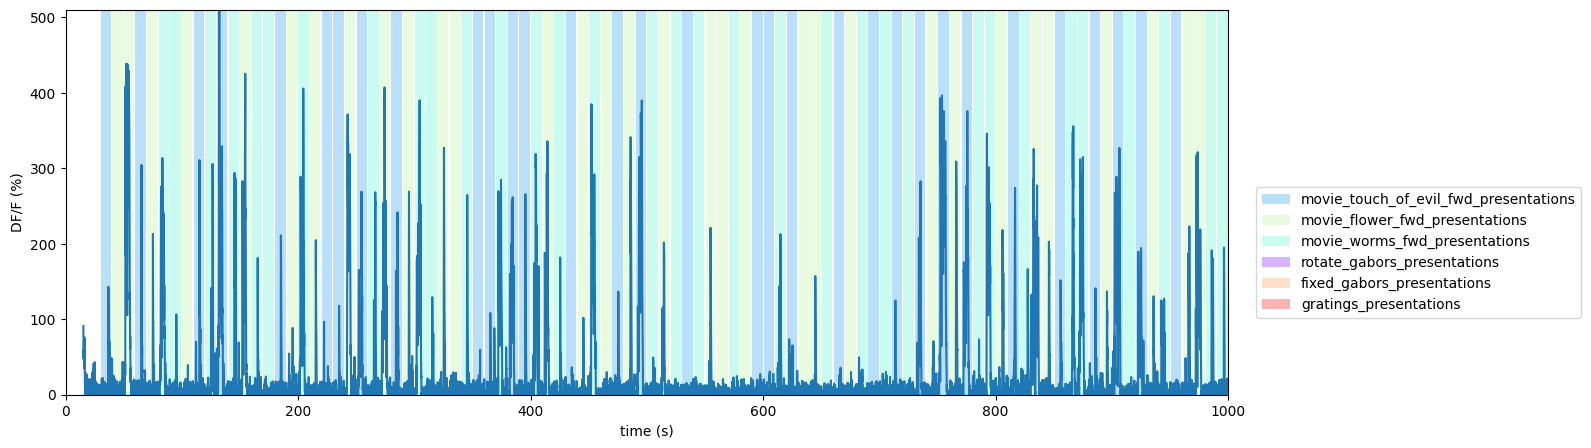

In [14]:
# generate plot of spike histogram with colored epoch intervals and legend
fig, ax = plt.subplots(figsize=(15,5))

# assign unique color to each stimulus name
stim_names = list({epoch[0] for epoch in epochs})
colors = plt.cm.rainbow(np.linspace(0,1,len(stim_names)))
stim_color_map = {stim_names[i]:colors[i] for i in range(len(stim_names))}

epoch_key = {}
height = max(trace_to_display) # change this to set height of the plot
# draw colored rectangles for each epoch
for epoch in epochs:
    stim_name, stim_block, epoch_start, epoch_end = epoch
    color = stim_color_map[stim_name]
    rec = ax.add_patch(mpl.patches.Rectangle((epoch_start, 0), epoch_end-epoch_start, height, alpha=0.3, facecolor=color))
    epoch_key[stim_name] = rec

ax.set_xlim(time_start, time_end)
ax.set_ylim(0, height)
ax.set_xlabel("time (s)")
ax.set_ylabel("DF/F (%)")

fig.legend(epoch_key.values(), epoch_key.keys(), loc="lower right", bbox_to_anchor=(1.14, 0.25))
ax.plot(dff_timestamps[:], trace_to_display)

### Visualizing Fluorescence Over Time
Here a 2D plot is made showing ROI DF/F values over time. Without organizing the ROIs, there are limits to how useful it can be. Set `interval_start` and `interval_end` to the bounds of time, in seconds, you'd like to see displayed. These bounds get translated into the indices of the dff trace that match most closely to the time that was provided. If the bounds are outside the measurement period, an error be thrown. You may also set `start_unit` and `end_unit` to narrow the number of ROIs that will be displayed.

In [15]:
interval_start = 3700
interval_end = 3900

start_roi = 0
end_roi = dff_trace.shape[1] # show all units

In [16]:
# translate interval time bounds into approximate data indices
interval_start_idx, interval_end_idx = None, None
for i in range(len(dff_timestamps)):
    if dff_timestamps[i] >= interval_start and not interval_start_idx:
        interval_start_idx = i
    if dff_timestamps[i] >= interval_end and not interval_end_idx:
        interval_end_idx = i
    if interval_start_idx and interval_end_idx:
        break
else:
    raise IndexError("Interval start and Interval end times were not found within the data duration")

if interval_start_idx == interval_end_idx:
    raise IndexError("Interval bounds are equal; Interval has length 0")
    
print(interval_start_idx, interval_end_idx)

39579 41727


Text(0.5, 1.0, 'ROIs DF/F over time')

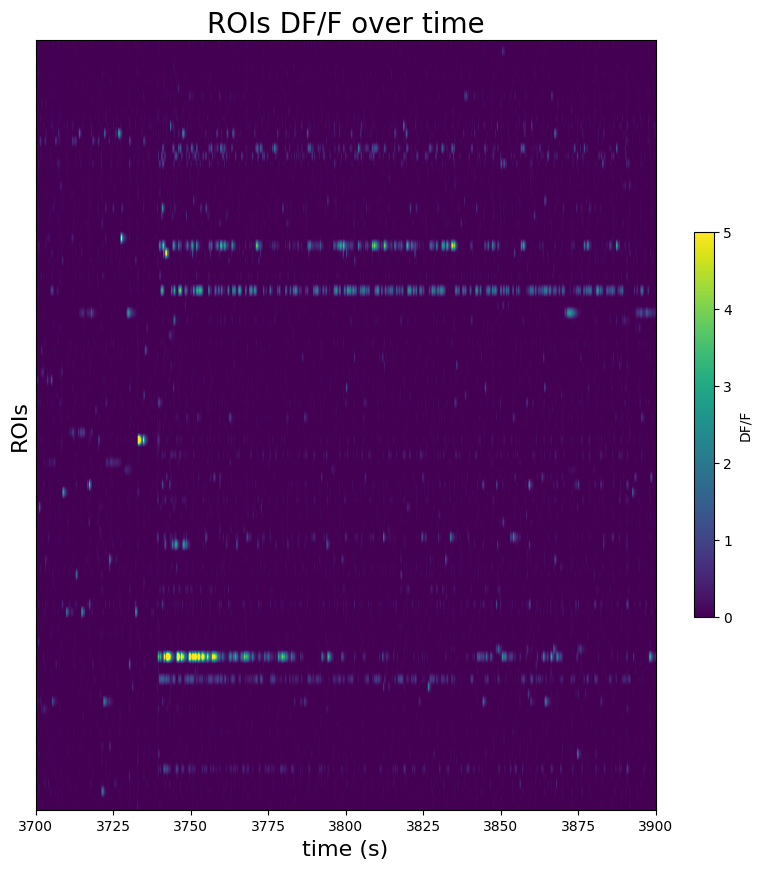

In [17]:
# display array of ROI DF/F traces as 2D image with color
fig, ax = plt.subplots(figsize=(10,10))

vmin, vmax = 0, 5 # adjust these to change contrast of DF/F values in the plot
img = ax.imshow(np.transpose(dff_trace[interval_start_idx:interval_end_idx]), extent=[interval_start,interval_end,start_roi,end_roi], aspect='auto', vmax=vmin, vmin=vmax)
cbar = plt.colorbar(img, shrink=0.5)
cbar.set_label('DF/F')

ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel("ROIs", fontsize=16)
ax.set_xlabel("time (s)", fontsize=16)
ax.set_title("ROIs DF/F over time", fontsize=20)